<a href="https://colab.research.google.com/github/donw385/DS-Unit-2-Sprint-3-Advanced-Regression/blob/master/module3-quantile-regression/LS_DS_233_Quantile_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Quantile Regression

Regressing towards the median - or any quantile - as a way to mitigate outliers and control risk.

## Lecture

Let's look at data that has a bit of a skew to it:

http://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

In [0]:
import pandas as pd
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/'
                 '00381/PRSA_data_2010.1.1-2014.12.31.csv')

In [22]:
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [23]:
df.describe()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
count,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,41757.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,21912.500000,2012.000000,6.523549,15.727820,11.500000,98.613215,1.817246,12.448521,1016.447654,23.889140,0.052734,0.194916
std,12651.043435,1.413842,3.448572,8.799425,6.922266,92.050387,14.433440,12.198613,10.268698,50.010635,0.760375,1.415867
min,1.000000,2010.000000,1.000000,1.000000,0.000000,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,10956.750000,2011.000000,4.000000,8.000000,5.750000,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,21912.500000,2012.000000,7.000000,16.000000,11.500000,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,32868.250000,2013.000000,10.000000,23.000000,17.250000,137.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,43824.000000,2014.000000,12.000000,31.000000,23.000000,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


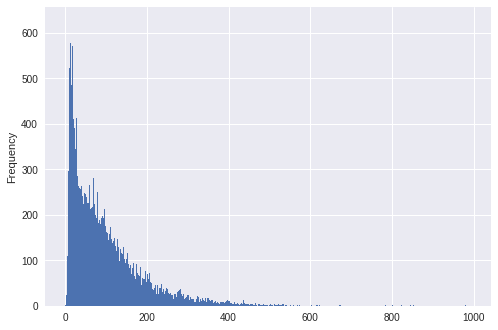

In [24]:
#extreme right skew, mean much greater than median

df['pm2.5'].plot.hist(bins=1000);

In [25]:
# How does linear regression handle it? R^2 of 0.26
from sklearn.linear_model import LinearRegression

# Let's drop NAs and limit to numeric values
df = df._get_numeric_data().dropna()
X = df.drop('pm2.5', axis='columns')
y = df['pm2.5']

linear_reg = LinearRegression().fit(X, y)
linear_reg.score(X, y)

0.2590006399659215

In [26]:
# Not bad - but what if we wanted to model the distribution more conservatively?
# Let's try quantile
import statsmodels.formula.api as smf

# Different jargon/API in StatsModel documentation
# "endogenous" response var is dependent (y), it is "inside"
# "exogenous" variables are independent (X), it is "outside"
# Bonus points - talk about "exogenous shocks" and you're a bona fide economist

# ~ style formulas look like what R uses
# y ~ x1 + x2 + ...
# Also, these formulas break with . in variable name, so lets change that
df = df.rename(index=str, columns={'pm2.5': 'pm25'})

# Now let's construct the formula string using all columns
quant_formula = 'pm25 ~ ' + ' + '.join(df.drop('pm25', axis='columns').columns)
print(quant_formula)

quant_mod = smf.quantreg(quant_formula, data=df)
quant_reg = quant_mod.fit(q=.5) #fitting to quantile, 0.5 is fitting to median
quant_reg.summary()  # "summary" is another very R-thing

pm25 ~ No + year + month + day + hour + DEWP + TEMP + PRES + Iws + Is + Ir


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                   pm25   Pseudo R-squared:               0.1600
Model:                       QuantReg   Bandwidth:                       8.276
Method:                 Least Squares   Sparsity:                        133.8
Date:                Wed, 27 Feb 2019   No. Observations:                41757
Time:                        18:44:26   Df Residuals:                    41745
                                        Df Model:                           11
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0004   1.67e-05     22.881      0.000       0.000       0.000
No           3.63e-07   2.67e-05      0.014      0.989    -5.2e-05    5.27e-05
year           0.8830      0.031     28.631      0.000       0.823       0.943
month         -1.4110      0.103    -13.749      0.000      -1.612      -1.210
day            0.4461      0.037     11.951      0.000       0.373       0.519
hour           1.2810      0.050     25.779      0.000       1.184       1.378
DEWP           3.6362      0.047     77.315      0.000       3.544       3.728
TEMP          -4.7103      0.060    -78.779      0.000      -4.828      -4.593
PRES          -1.6265      0.061    -26.760      0.000      -1.746      -1.507
Iws           -0.1541      0.007    -21.786      0.000      -0.168      -0.140
Is            -1.6322      0.425     -3.838      0.000      -2.466      -0.799
Ir            -5.3946      0.234    -23.034      0.000      -5.854      -4.936
==============================================================================

The condition number is large, 3.67e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

That fit to the median (q=0.5), also called "Least Absolute Deviation." The pseudo-R^2 isn't really directly comparable to the R^2 from linear regression, but it clearly isn't dramatically improved. Can we make it better?

In [27]:
help(quant_mod.fit)

Help on method fit in module statsmodels.regression.quantile_regression:

fit(q=0.5, vcov='robust', kernel='epa', bandwidth='hsheather', max_iter=1000, p_tol=1e-06, **kwargs) method of statsmodels.regression.quantile_regression.QuantReg instance
    Solve by Iterative Weighted Least Squares
    
    Parameters
    ----------
    q : float
        Quantile must be between 0 and 1
    vcov : string, method used to calculate the variance-covariance matrix
        of the parameters. Default is ``robust``:
    
        - robust : heteroskedasticity robust standard errors (as suggested
          in Greene 6th edition)
        - iid : iid errors (as in Stata 12)
    
    kernel : string, kernel to use in the kernel density estimation for the
        asymptotic covariance matrix:
    
        - epa: Epanechnikov
        - cos: Cosine
        - gau: Gaussian
        - par: Parzene
    
    bandwidth: string, Bandwidth selection method in kernel density
        estimation for asymptotic covarian

In [28]:
quantiles = (.05, .96, .1)

for quantile in quantiles:
  print(quant_mod.fit(q=quantile).summary())

                         QuantReg Regression Results                          
Dep. Variable:                   pm25   Pseudo R-squared:              0.04130
Model:                       QuantReg   Bandwidth:                       8.908
Method:                 Least Squares   Sparsity:                        120.7
Date:                Wed, 27 Feb 2019   No. Observations:                41757
Time:                        18:44:28   Df Residuals:                    41745
                                        Df Model:                           11
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.072e-05    6.4e-06      4.803      0.000    1.82e-05    4.33e-05
No         -6.994e-05   9.59e-06     -7.292      0.000   -8.87e-05   -5.11e-05
year           0.0998      0.012      8.275      0.000       0.076       0.123
month         -0.4536      0.034    -13.419      0.0

"Strong multicollinearity", eh? In other words - maybe we shouldn't throw every variable in our formula. Let's hand-craft a smaller one, picking the features with the largest magnitude t-statistics for their coefficients. Let's also search for more quantile cutoffs to see what's most effective.

In [29]:
# quant_formula = 'pm25 ~ DEWP + TEMP + Ir + hour + Iws'
# quant_mod = smf.quantreg(quant_formula, data=df)
# for quantile in range(50, 100):
#   quantile /= 100
#   quant_reg = quant_mod.fit(q=quantile)
#   print((quantile, quant_reg.prsquared))

(0.5, 0.1447879336023583)
(0.51, 0.1453046499109799)
(0.52, 0.1457984456251047)
(0.53, 0.14627848333343263)
(0.54, 0.1467640446791706)
(0.55, 0.14733094668790292)
(0.56, 0.14787821797693512)
(0.57, 0.14840185621049273)
(0.58, 0.14892138273908107)
(0.59, 0.14946793972061212)


KeyboardInterrupt: ignored

In [30]:
# Okay, this data seems *extremely* skewed
# Let's trying logging
import numpy as np

df['pm25'] = np.log(1 + df['pm25'])
quant_mod = smf.quantreg(quant_formula, data=df)
quant_reg = quant_mod.fit(q=.25)
quant_reg.summary()  # "summary" is another very R-thing

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                   pm25   Pseudo R-squared:               0.2292
Model:                       QuantReg   Bandwidth:                      0.1012
Method:                 Least Squares   Sparsity:                        2.806
Date:                Wed, 27 Feb 2019   No. Observations:                41757
Time:                        18:44:55   Df Residuals:                    41751
                                        Df Model:                            5
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.2444      0.013    318.116      0.000       4.218       4.271
DEWP           0.0722      0.001     96.780      0.000       0.071       0.074
TEMP          -0.0701      0.001    -83.629      0.000      -0.072      -0.068
Ir            -0.1079      0.004    -29.400      0.000      -0.115      -0.101
hour           0.0215      0.001     23.206      0.000       0.020       0.023
Iws           -0.0040      0.000    -36.706      0.000      -0.004      -0.004
==============================================================================
"""

Overall - in this case, quantile regression is not *necessarily* superior to linear regression. But it does give us extra flexibility and another thing to tune - what the center of what we're actually fitting in the dependent variable.

The basic case of `q=0.5` (the median) minimizes the absolute value of residuals, while OLS minimizes the squared value. By selecting `q=0.25`, we're targeting a lower quantile and are effectively saying that we only want to over-estimate at most 25% of the time - we're being *risk averse*.

Depending on the data you're looking at, and the cost of making a false positive versus a false negative, this sort of flexibility can be extremely useful.

Live - let's consider another dataset! Specifically, "SkillCraft" (data on competitive StarCraft players): http://archive.ics.uci.edu/ml/datasets/SkillCraft1+Master+Table+Dataset

In [31]:
# TODO Live!
# Hint - we may only care about the *top* quantiles here
# Another hint - there are missing values, but Pandas won't see them right away

import pandas as pd

df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/00272/SkillCraft1_Dataset.csv')
df.head()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,55,5,23,10,5000,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001194,5,0.0,0.000208
2,56,4,30,10,200,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
3,57,3,19,20,400,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
4,58,3,32,10,500,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019


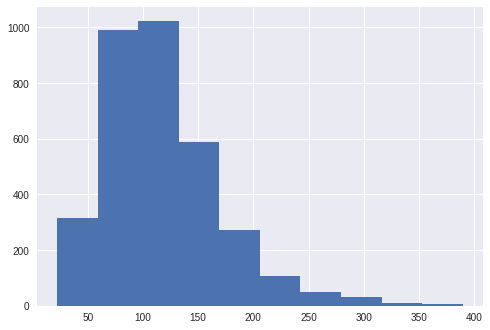

In [32]:
df['APM'].hist()

In [0]:
import numpy as np

df.replace('?', np.nan, inplace=True)

In [34]:
df.isnull().sum()

GameID                   0
LeagueIndex              0
Age                     55
HoursPerWeek            56
TotalHours              57
APM                      0
SelectByHotkeys          0
AssignToHotkeys          0
UniqueHotkeys            0
MinimapAttacks           0
MinimapRightClicks       0
NumberOfPACs             0
GapBetweenPACs           0
ActionLatency            0
ActionsInPAC             0
TotalMapExplored         0
WorkersMade              0
UniqueUnitsMade          0
ComplexUnitsMade         0
ComplexAbilitiesUsed     0
dtype: int64

In [0]:
df = df.dropna()

In [0]:
#coerce turns string to NaN, so wouldnt have needed to use replace earlier

df['Age'] = pd.to_numeric(df['Age'], errors='coerce')

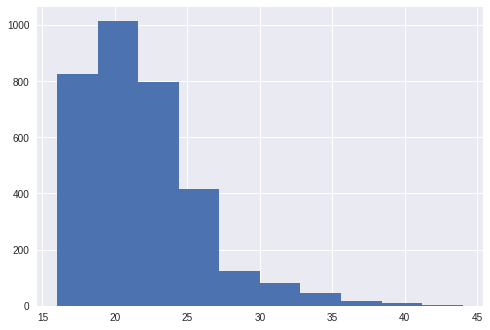

In [37]:
df['Age'].hist()

In [0]:
hasNaN = ['Age', 'HoursPerWeek', 'TotalHours']

for feature in hasNaN:
  df[feature] = pd.to_numeric(df[feature], errors="coerce")

In [39]:
df.describe()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
count,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000
mean,4719.552127,4.120731,21.650389,15.909527,960.421809,114.575763,0.004023,0.000364,4.316357,0.000094,0.000380,0.003433,40.713819,64.209584,5.266955,22.116836,0.001031,6.541043,0.000060,0.000142
std,2656.919630,1.448170,4.206357,11.964495,17318.133922,48.111912,0.004726,0.000210,2.333322,0.000159,0.000359,0.000966,17.057191,19.037394,1.500605,7.440875,0.000520,1.859049,0.000112,0.000266
min,52.000000,1.000000,16.000000,0.000000,3.000000,22.059600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000679,6.666700,24.632600,2.038900,5.000000,0.000077,2.000000,0.000000,0.000000
25%,2423.250000,3.000000,19.000000,8.000000,300.000000,79.231500,0.001245,0.000202,3.000000,0.000000,0.000139,0.002743,29.326600,50.886425,4.261525,17.000000,0.000682,5.000000,0.000000,0.000000
50%,4788.000000,4.000000,21.000000,12.000000,500.000000,107.070300,0.002445,0.000349,4.000000,0.000039,0.000278,0.003376,37.058900,61.296100,5.087050,22.000000,0.000904,6.000000,0.000000,0.000020
75%,6994.750000,5.000000,24.000000,20.000000,800.000000,140.156100,0.004945,0.000493,6.000000,0.000113,0.000508,0.004003,48.510425,74.032525,6.027350,27.000000,0.001258,8.000000,0.000087,0.000182
max,9271.000000,7.000000,44.000000,168.000000,1000000.000000,389.831400,0.043088,0.001648,10.000000,0.003019,0.003688,0.007971,237.142900,176.372100,18.558100,58.000000,0.005149,13.000000,0.000902,0.003084


In [40]:
df.loc[df['LeagueIndex']==7]



,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
7,72,7,17,42,10000,212.6022,0.009040,0.000676,6,0.001164,0.001253,0.004952,24.6117,41.7671,6.6104,45,0.002277,9,0.000129,0.000249
104,357,7,21,24,1000,286.4538,0.017852,0.000717,6,0.000049,0.001298,0.006206,20.4232,30.9801,5.7171,30,0.001372,6,0.000000,0.000000
119,398,7,24,16,1250,216.6852,0.011957,0.000396,6,0.000528,0.000839,0.005691,21.6119,32.6225,5.0083,33,0.000688,8,0.000038,0.000000
320,953,7,25,42,2400,182.6208,0.005607,0.000310,8,0.000203,0.000662,0.005254,24.4969,38.6260,5.4065,18,0.001164,7,0.000000,0.000000
368,1096,7,19,56,1700,130.8600,0.003419,0.000552,5,0.000104,0.000069,0.003108,18.7416,52.3111,6.6667,15,0.000932,5,0.000000,0.000000
407,1216,7,23,24,1400,203.9028,0.006647,0.000461,7,0.000135,0.000967,0.006130,24.5515,33.2917,4.7358,29,0.002486,9,0.000112,0.000067
500,1463,7,17,56,1600,202.0026,0.013070,0.000816,4,0.000149,0.000378,0.006615,20.0964,33.9368,3.7699,25,0.001154,7,0.000000,0.000000
687,1988,7,18,24,500,172.3362,0.004740,0.000717,5,0.000235,0.000353,0.007971,18.0054,30.2604,3.3221,27,0.000920,6,0.000000,0.000000
698,2029,7,19,28,1466,234.7176,0.011472,0.000936,8,0.000092,0.000910,0.004602,15.0575,43.1519,7.0774,33,0.003191,7,0.000053,0.000000
713,2076,7,23,56,2400,136.2432,0.006425,0.000855,10,0.000010,0.000185,0.005132,28.0987,39.9318,4.0322,33,0.001118,10,0.000107,0.000826


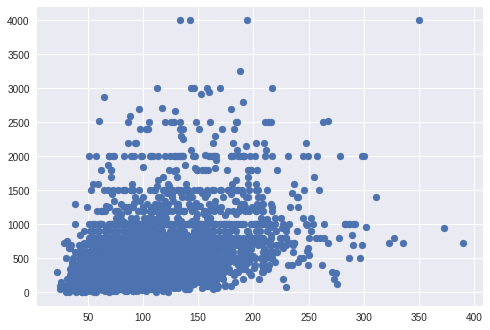

In [41]:
df = df[df['TotalHours']<5000]
plt.scatter(df['APM'], df['TotalHours'])
plt.show()

In [42]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

y=df['APM']
X=df.drop('APM',axis='columns')

model.fit(X,y)
model.score(X,y)

0.972573971332772

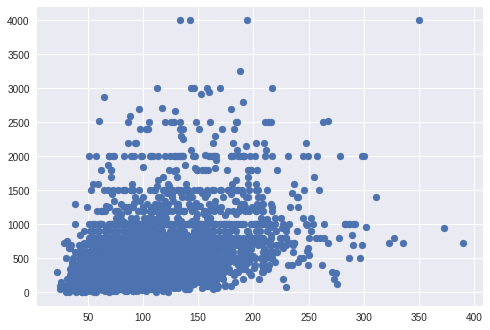

In [43]:
import matplotlib.pyplot as plt

plt.scatter(df['APM'], df['TotalHours'])
plt.show()

In [44]:
quant_formula = 'APM ~ ' + ' + '.join(df.drop('APM', axis='columns').columns)
print(quant_formula)

APM ~ GameID + LeagueIndex + Age + HoursPerWeek + TotalHours + SelectByHotkeys + AssignToHotkeys + UniqueHotkeys + MinimapAttacks + MinimapRightClicks + NumberOfPACs + GapBetweenPACs + ActionLatency + ActionsInPAC + TotalMapExplored + WorkersMade + UniqueUnitsMade + ComplexUnitsMade + ComplexAbilitiesUsed


In [51]:


quant_mod = smf.quantreg(quant_formula, data=df)
quant_reg = quant_mod.fit(q=.9) #fitting to quantile, 0.5 is fitting to median, .9 is top 10%
quant_reg.summary()  # "summary" is another very R-thing

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:193: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                    APM   Pseudo R-squared:               0.8923
Model:                       QuantReg   Bandwidth:                       1.353
Method:                 Least Squares   Sparsity:                        28.91
Date:                Wed, 27 Feb 2019   No. Observations:                 3325
Time:                        18:49:46   Df Residuals:                     3305
                                        Df Model:                           19
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             -107.8652      3.044    -35.437      0.000    -113.833    -101.897
GameID                2.087e-05   5.66e-05      0.369      0.712      -9e-05       0.000
LeagueIndex             -0.4397      0.154     -2.848      0.004      -0.742      -0.137
Age                      0.0666      0.042      1.581      0.114      -0.016       0.149
HoursPerWeek             0.0351      0.015      2.283      0.023       0.005       0.065
TotalHours              -0.0002      0.000     -0.434      0.664      -0.001       0.001
SelectByHotkeys       5408.7599     39.088    138.373      0.000    5332.120    5485.399
AssignToHotkeys       -326.7892   1037.899     -0.315      0.753   -2361.780    1708.201
UniqueHotkeys            0.0126      0.069      0.183      0.855      -0.122       0.147
MinimapAttacks        2417.9964   1046.642      2.310      0.021     365.865    4470.128
MinimapRightClicks    2562.2417    490.175      5.227      0.000    1601.165    3523.318
NumberOfPACs           3.14e+04    399.744     78.538      0.000    3.06e+04    3.22e+04
GapBetweenPACs           0.0911      0.014      6.311      0.000       0.063       0.119
ActionLatency            0.1028      0.021      4.860      0.000       0.061       0.144
ActionsInPAC            17.6057      0.153    114.909      0.000      17.305      17.906
TotalMapExplored        -0.1022      0.030     -3.433      0.001      -0.161      -0.044
WorkersMade            868.3935    331.954      2.616      0.009     217.537    1519.250
UniqueUnitsMade         -0.3024      0.105     -2.880      0.004      -0.508      -0.097
ComplexUnitsMade     -1976.4192    156.573    -12.623      0.000   -2283.409   -1669.429
ComplexAbilitiesUsed -4253.0208    629.360     -6.758      0.000   -5486.995   -3019.046
========================================================================================

The condition number is large, 6.79e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Assignment - birth weight data

Birth weight is a situation where, while the data itself is actually fairly normal and symmetric, our main goal is actually *not* to model mean weight (via OLS), but rather to identify mothers at risk of having children below a certain "at-risk" threshold weight.

Quantile regression gives us just the tool we need. For the data we are using, see: http://people.reed.edu/~jones/141/BirthWgt.html

    bwt: baby's weight in ounces at birth
    gestation: duration of pregnancy in days
    parity: parity indicator (first born = 1, later birth = 0)
    age: mother's age in years
    height: mother's height in inches
    weight: mother's weight in pounds (during pregnancy)
    smoke: indicator for whether mother smokes (1=yes, 0=no) 
    
Use this data and `statsmodels` to fit a quantile regression, predicting `bwt` (birth weight) as a function of the other covariates. First, identify an appropriate `q` (quantile) to target a cutoff of 90 ounces - babies above that birth weight are generally healthy/safe, babies below are at-risk.

Then, fit and iterate your model. Be creative! You may want to engineer features. Hint - mother's age likely is not simply linear in its impact, and the other features may interact as well.

At the end, create at least *2* tables and *1* visualization to summarize your best model. Then (in writing) answer the following questions:

- What characteristics of a mother indicate the highest likelihood of an at-risk (low weight) baby?
- What can expectant mothers be told to help mitigate this risk?

Note that second question is not exactly a data science question - and that's okay! You're not expected to be a medical expert, but it is a good exercise to do a little bit of digging into a particular domain and offer informal but informed opinions.

In [46]:
import pandas as pd
bwt_df = pd.read_csv('http://people.reed.edu/~jones/141/Bwt.dat')
bwt_df.head()

,bwt,gestation,parity,age,height,weight,smoke
0,120,284,0,27,62,100,0
1,113,282,0,33,64,135,0
2,128,279,0,28,64,115,1
3,108,282,0,23,67,125,1
4,136,286,0,25,62,93,0


In [47]:
bwt_df.describe()

,bwt,gestation,parity,age,height,weight,smoke
count,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000
mean,119.462521,279.101363,0.262351,27.228279,64.049404,128.478705,0.390971
std,18.328671,16.010305,0.440100,5.817839,2.526102,20.734282,0.488176
min,55.000000,148.000000,0.000000,15.000000,53.000000,87.000000,0.000000
25%,108.000000,272.000000,0.000000,23.000000,62.000000,114.250000,0.000000
50%,120.000000,280.000000,0.000000,26.000000,64.000000,125.000000,0.000000
75%,131.000000,288.000000,1.000000,31.000000,66.000000,139.000000,1.000000
max,176.000000,353.000000,1.000000,45.000000,72.000000,250.000000,1.000000


In [0]:
# TODO - your work here! Also, add text cells for written questions.

## Resources and stretch goals

Resources:
- [statsmodels QuantReg example](http://www.statsmodels.org/dev/examples/notebooks/generated/quantile_regression.html)
- [How Shopify used Quantile Regression in modeling risk](https://medium.com/data-shopify/how-shopify-capital-uses-quantile-regression-to-help-merchants-succeed-10ee1b36b17d)

Stretch goals:
- Find a dataset where you think quantile regression may be appropriate, and try both it and linear regression - compare/contrast their strengths/weaknesses, and write a summary for which you think is better for the situation and why
- Check out [deep quantile regression](https://www.kdnuggets.com/2018/07/deep-quantile-regression.html), an approach that uses a custom quantile loss function and Keras to train a quantile model